In [1]:
# !pip3 install ipywidgets -q
# seaborn is outdated
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader as DL, random_split

import albumentations as A
# I've found a weird way to transform bounding boxes, labels (some of those may disappear) and images altogether in a same manner

In [3]:
from model import YOLO3
from modules import FiguresDataset, YOLOLoss
from training import DEVICE, train, load_ch, splits
from aux_utils import show_img, pick, sample, get_anchors, batch_sample

1600 images, boxes, class indices have been loaded successfully.
Image statistics has not been calculated, use builtins
400 images, boxes, class indices have been loaded successfully.
Image statistics has not been calculated, use builtins


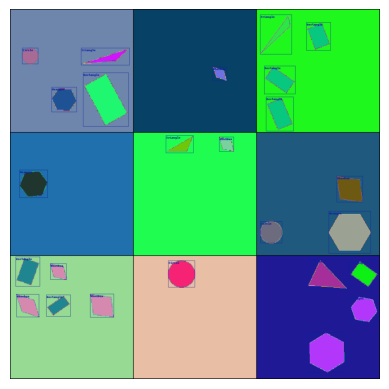

In [4]:
CAP = 2000 # take subset 0...CAP of overall data
TRAIN_ON = 0.8 # proportion of training data within that subset

train_part, test_part = splits(p=TRAIN_ON, cap_length=CAP) # returns 2 slices
augmentations = [A.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1, hue=0.1, p=0.1), A.HorizontalFlip(p=0.5),]

ds_train = FiguresDataset(part=train_part, aug=augmentations)
ds_test = FiguresDataset(part=test_part)
gsa = {'gs': ds_train.grid_sizes, 'anchors': ds_train.anchors}
sample(ds_train, **gsa)

Images are torch.float32 tensors shaped torch.Size([3, 416, 416])
Targets are tuples containing 3 sparse tensors for each scale shaped [torch.Size([3, 13, 13, 6]), torch.Size([3, 26, 26, 6]), torch.Size([3, 52, 52, 6])]


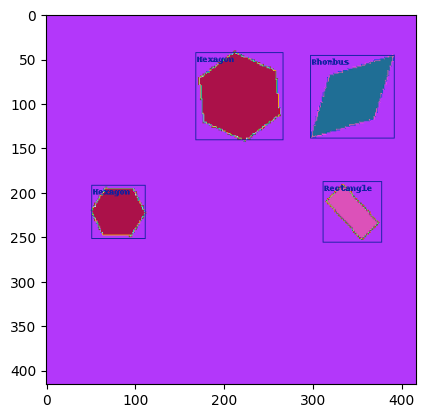

In [5]:
K = 1001
show_img(pick(ds_train[K], **gsa), slim=False)
print(f"Images are {ds_train[K][0].dtype} tensors shaped {ds_train[K][0].shape}")
print(f"Targets are tuples containing {len(ds_train[K][1])} sparse tensors for each scale shaped {[ds_train[K][1][i].shape for i in range(len(ds_train[K][1]))]}")

In [6]:
print(f'K-th element has {ds_train[K][1][0].count_nonzero().item()} nonzero elements of {ds_train[K][1][0].numel()} total')
print(ds_train[K][1][0].nonzero())

K-th element has 24 nonzero elements of 3042 total
tensor([[ 0,  2,  6,  0],
        [ 0,  2,  6,  1],
        [ 0,  2,  6,  2],
        [ 0,  2,  6,  3],
        [ 0,  2,  6,  4],
        [ 0,  2,  6,  5],
        [ 0,  6,  2,  0],
        [ 0,  6,  2,  1],
        [ 0,  6,  2,  2],
        [ 0,  6,  2,  3],
        [ 0,  6,  2,  4],
        [ 0,  6,  2,  5],
        [ 0, 10,  2,  0],
        [ 0, 10,  2,  1],
        [ 0, 10,  2,  2],
        [ 0, 10,  2,  3],
        [ 0, 10,  2,  4],
        [ 0, 10,  2,  5],
        [ 0, 10,  6,  0],
        [ 0, 10,  6,  1],
        [ 0, 10,  6,  2],
        [ 0, 10,  6,  3],
        [ 0, 10,  6,  4],
        [ 0, 10,  6,  5]])


## Anchors concept (for YOLO)

https://arxiv.org/pdf/1804.02767.pdf

Each cell has to predict ONE object (=one of its bboxes) if its center falls into receiptive field. 

Suppose that a cell can predict a fixed amount of bounding boxes (B=3 for v3) and each of those tends to 'specialize' in detecting particular type(proportion, scale) of object (vertical human, horizontal car, square...)
We don't want to output xywh boxes directly (unstable gradients), instead:

1) Take some grid, pre-define 3 fixed boxes aka 'anchors' per cell, each centered within its cell, given as $[pw, ph]$- height and width (absolute)
2) Apply same grid to input image, get the cell containing GT bbox's center, take its coordinates $(cx, cy)$ (obviously relative to this grid) 
3) Switch to local coordinates (relative to that cell): 2 shifts (bbox's center from cell's tlc), width and height (bbox size is measured in #cells) 
4) Choose 'best' (by IoU) anchor of 3 and consider GT bbox as its transformation, let our network control 'offset' parameters $[tx, ty, tw, th]$ of such transformation:
\begin{split}
\underbrace{x_{rc} - cx}_{shift-cx} = \sigma(tx)\\
\underbrace{y_{rc} - cy}_{shift-cy} = \sigma(tx)\\
w_{rc} =pw*e^{tw}\\
h_{rc} =ph*e^{th}
\end{split}
5) Repeat this procedure for the other grids (different cell size, different anchor set) ~ locate bbox on all possible scales (up to 3)

NB: 1 anchor to 1 GT bbox per scale, i.e. if we have several good-performing options, we take one (best) and suppress the rest, completely exclude from future use (NMS algorithm)

From now on, this bbox could be uniquely determined in 2 steps: 
* roughly w/ (grid_size_id, anchor_id, cx, cy)
* refine w/ local (shift_x, shift_y, width, height)

Anchors are given before training, represent some prior knowledge about this dataset (typical object scale and aspect ratio). They are generated using k-means (not really means, euclidean metric is replaced by IoU score) clustering algorithm on all bboxes before training. 

Our dataset is by no means similar to COCO, that's why i am going to retrieve custom anchors

**NB: Doing just that lead to significant (3x) loss drop at once**

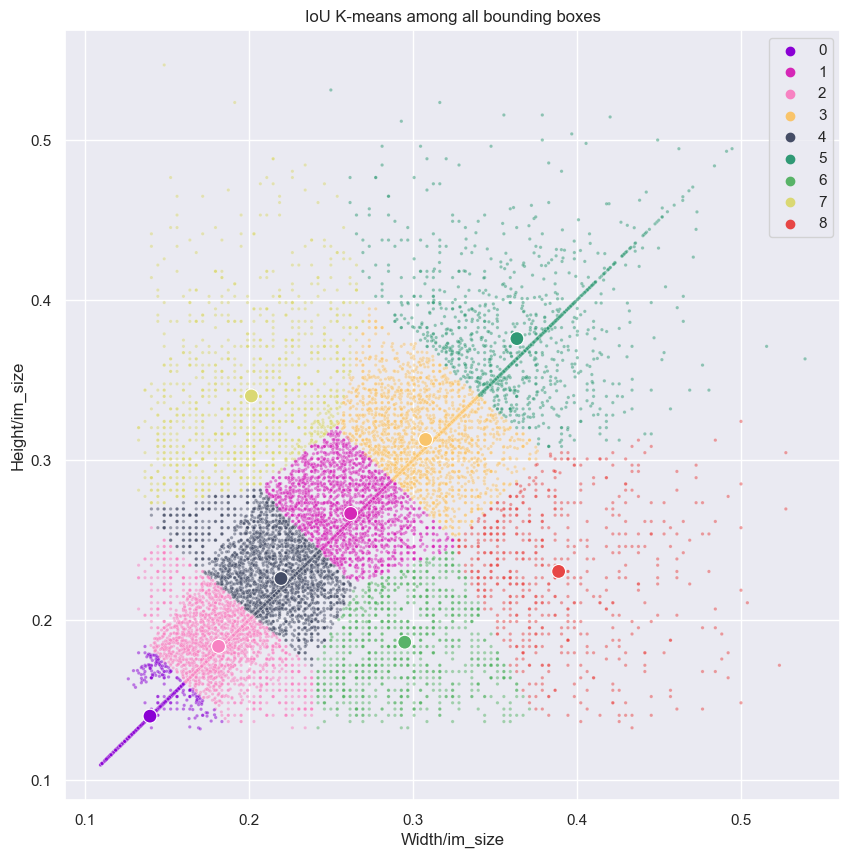

In [7]:
an = get_anchors(9)  # pre-calculated constant in modules.py, here for demonstration purposes only

In [8]:
ds_train.anchors, ds_train.grid_sizes

((((0.22838012478569927, 0.37234857956035894),
   (0.30127089816065944, 0.30470957552855793),
   (0.36307149222721874, 0.36530570814002944)),
  ((0.19109910688669632, 0.2804814482464234),
   (0.2570033528878385, 0.25741008305321017),
   (0.3500616294989826, 0.20384630961828798)),
  ((0.13782940739183006, 0.13803015194462828),
   (0.17738931739948338, 0.17951509178104036),
   (0.21803462084789216, 0.21450175377012273))),
 (13, 26, 52))

## Model
YOLO is an agorithm that processes whole image in 1-pass manner using just convolutions

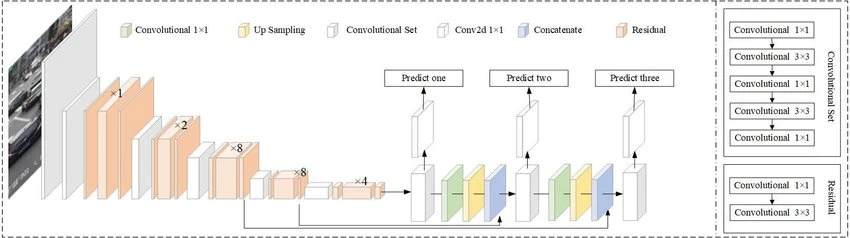

Our feature extractor (feature encoder) is somewhat typical, i.e. we stick to convolutional layers only, so that is FCN (but with bells and whistles), it outputs some feature map

But the classifier/regressor (feature decoder) is 1x1 convolution over feature map, result is called cell map (same size) 

## Yolo loss function

This task combines regression and classification, loss function contains 4 different weighted (bbox similarity and absence are less tolerated) losses: 
* object absence (BCE with logits)
* object presence (BCE with logits, but also learns to predict its IoU with GT bbox, treated as object probability)
* bbox similarity (MSE)
* class loss (CE)
  
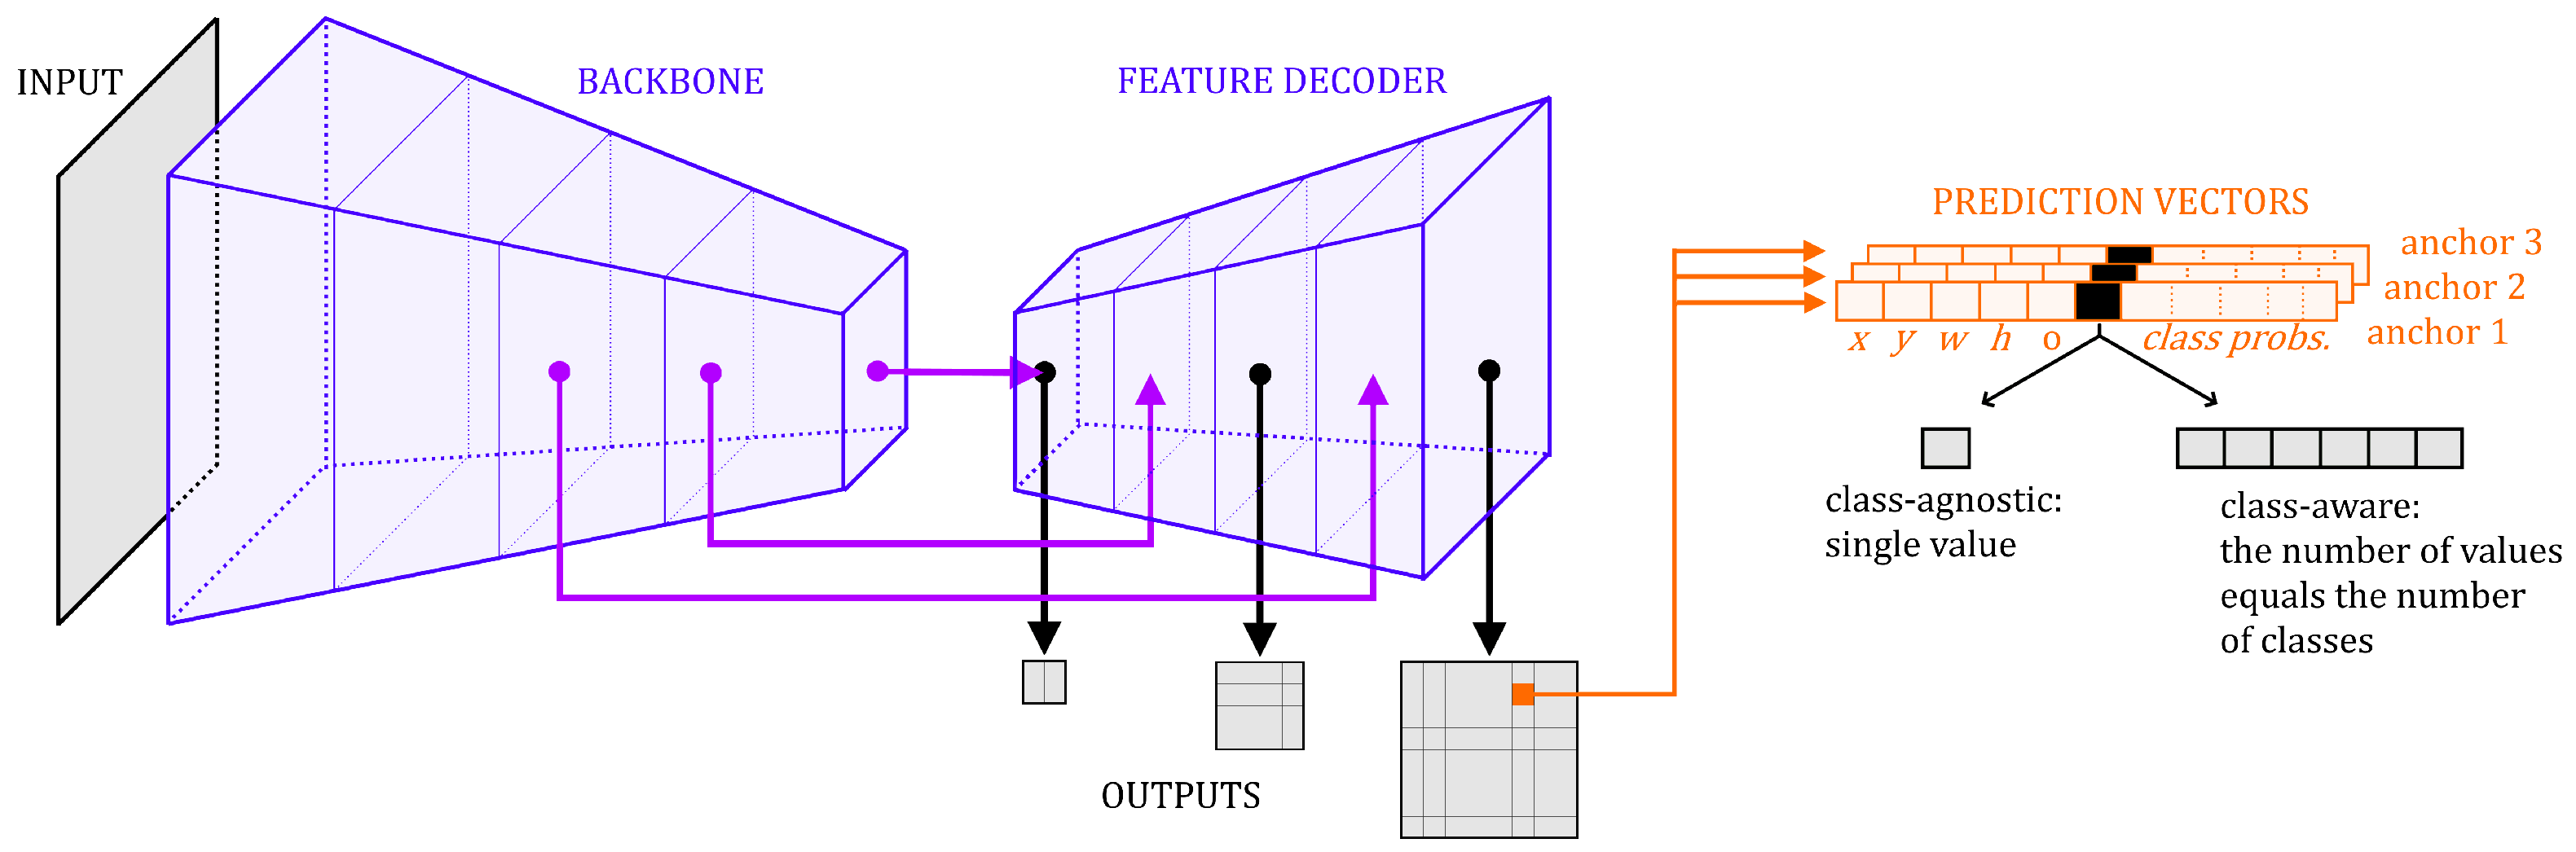
NB: We extract output and perform detection at 3 different scales, loss function is called separately for each scale

NB2: that BCE and thus total loss is NOT equal to zero even if we plug in same inputs, because BCE measures entropy $\mathbb{E}[p\log{p}]$ of distribution P instead of cross-entropy then

In [9]:
BATCH_SIZE = 16 #anything over 16 requires >8Gb of RAM installed, batches over 32 might be harder to train (~Yann LeCun)

train_l = DL(dataset=ds_train, batch_size=BATCH_SIZE, 
            shuffle=True,
            num_workers = 4,
            pin_memory = True if DEVICE == 'cuda' else False
           )

test_l = DL(dataset=ds_test, batch_size=2 * BATCH_SIZE, 
            shuffle=False,
            num_workers = 4,
            pin_memory = True if DEVICE == 'cuda' else False
           )

In [ ]:
LR = 1E-3 # anything over 1E-3 explodes
NUM_EPOCHS = 300 # if you load a checkpoint at some epoch, make sure to set this number > checkpoint epoch not to get an assertion error

In [ ]:
# instantiating
y_model = YOLO3()
y_loss = YOLOLoss(l_abs=10, l_prs=10, l_box=1, l_cls=1)

optim = torch.optim.Adam(y_model.parameters(), lr=LR)
gscaler = torch.cuda.amp.GradScaler() if DEVICE != 'cpu' else None

In [13]:
# actual BGD processing (with test inference each 2nd epoch), model and loss are automatically moved to default device (pre-defined in training module)
train(y_model, train_l, y_loss, optim, NUM_EPOCHS, amp_scaler=gscaler, dataloader_test=test_l, ep=1, load=True)

Checkpoint at epoch 263 with loss 23.12 has been loaded


Epoch:   0%|          | 0/37 [00:00<?, ?it/s]

  Batch:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

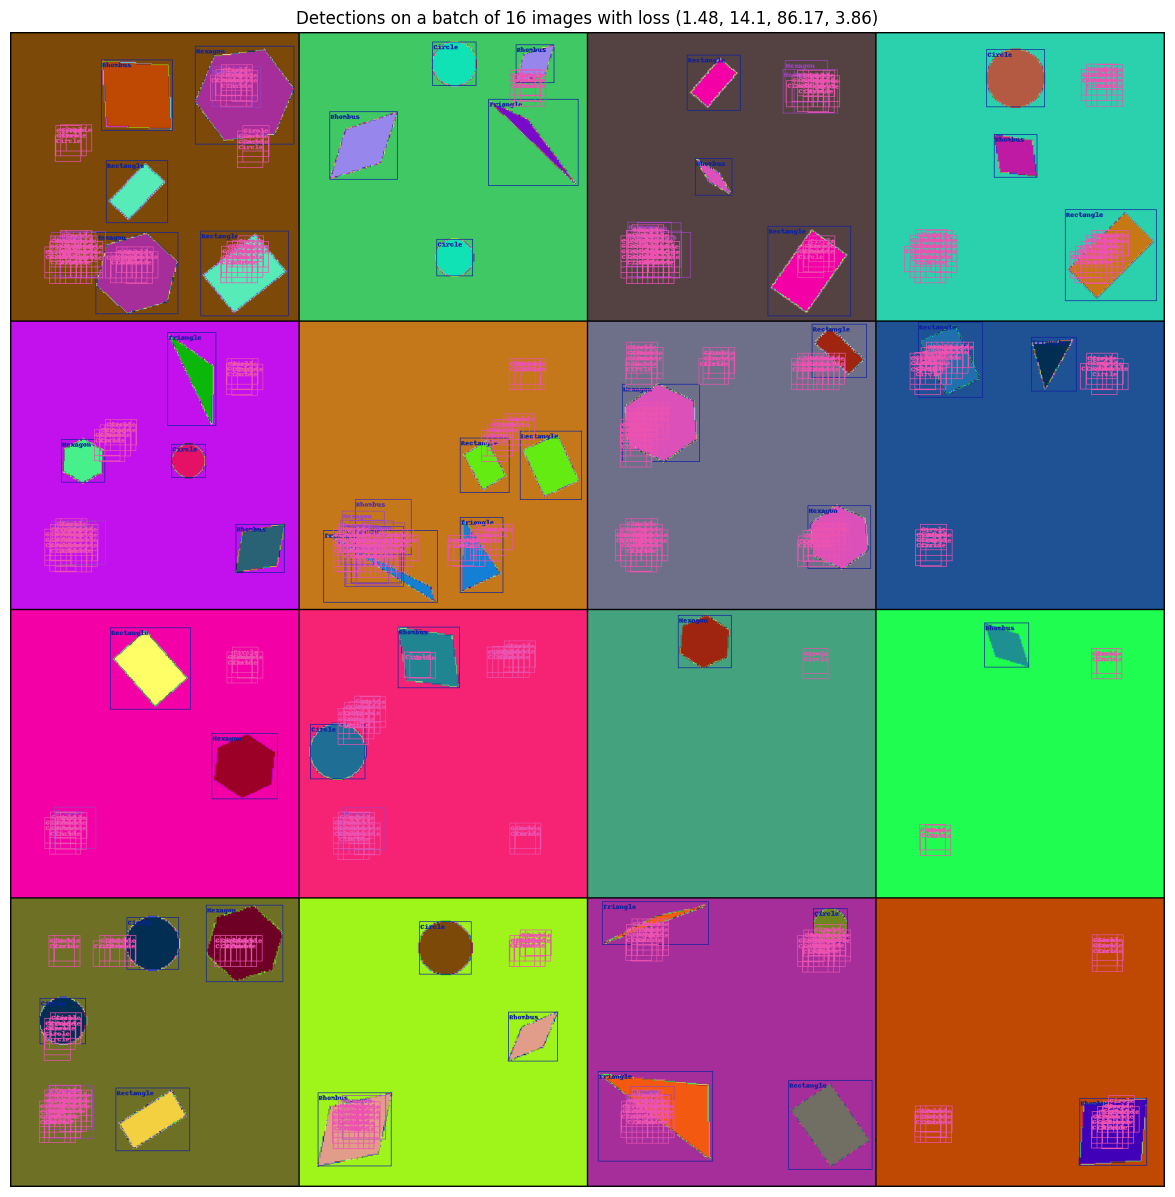

In [15]:
# from training import load_ch
# load_ch(y_model, optim)
x = next(iter(train_l))
batch_sample(x, model=y_model, loss_fn=y_loss, size=15, **gsa)